# Hypothesis-testing for CCC across Conditions

## Background

Cell-cell communication (CCC) events, while commonly inferred between cell types in steady-state data, can also be inferred between conditions. 

In contrast to dimensionality reduction approaches that reduce CCC into sets of loadings (See our tutorials on extracting intercellular programmes with [MOFA+](https://liana-py.readthedocs.io/en/latest/notebooks/mofatalk.html) and [Tensor-cell2cell](https://liana-py.readthedocs.io/en/latest/notebooks/liana_c2c.html)), hypothesis-driven differential expression analysis (DEA) tests can be used alternatively to test individual gene changes. 
In this tutorial, we perform DEA at the pseudobulk level to test for differential expression of genes between conditions, and then translate the results into deregulated complex-informed ligand-receptor interactions. Then we relate the deregulated interactions to intracellular signalling events.

We refer the user to the [Differential Gene expression chapter](https://www.sc-best-practices.org/conditions/differential_gene_expression.html) in the Single-cell best practices book, as well as to [decoupler's pseudobulk vignette](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html) for more details on the pseudobulk DEA.

## Load Packages

Install mofa, decoupler, and omnipath via pip with the following commands:

```python
pip install "decoupler>=0.1.4"
pip install omnipath
pip install "pydeseq2>=0.3.5"
```

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import plotnine as p9

import liana as li
import decoupler as dc

# Import DESeq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats

## Load & Prep Data

As a simple example, we will look at ~25k PBMCs from 8 pooled patient lupus samples, each before and after IFN-beta stimulation ([Kang et al., 2018](https://www.nature.com/articles/nbt.4042); [GSE96583](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE96583)). Note that by focusing on PBMCs, for the purpose of this tutorial, we assume that coordinated events occur among them.

This dataset is downloaded from a link on Figshare; preprocessed for [pertpy](https://github.com/theislab/pertpy).

In [2]:
adata = li.testing.datasets.kang_2018()
adata

AnnData object with n_obs × n_vars = 24673 × 15706
    obs: 'nCount_RNA', 'nFeature_RNA', 'tsne1', 'tsne2', 'condition', 'cluster', 'cell_type', 'patient', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.4', 'seurat_clusters', 'sample', 'cell_abbr'
    var: 'name'
    obsm: 'X_pca', 'X_umap'
    layers: 'counts'

Define columns of interest from `.obs`

Note that we use cell abbreviations because MOFA will use them as labels for the views.

In [3]:
sample_key = 'sample'
groupby = 'cell_abbr'
condition_key = 'condition'

### Basic QC

Note that this data has been largely pre-processed & annotated, we refer the user to the [Quality Control](https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html) and other relevant chapters from the best-practices book for information about pre-processing and annotation steps.

In [4]:
# filter cells and genes
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

### Showcase the data

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


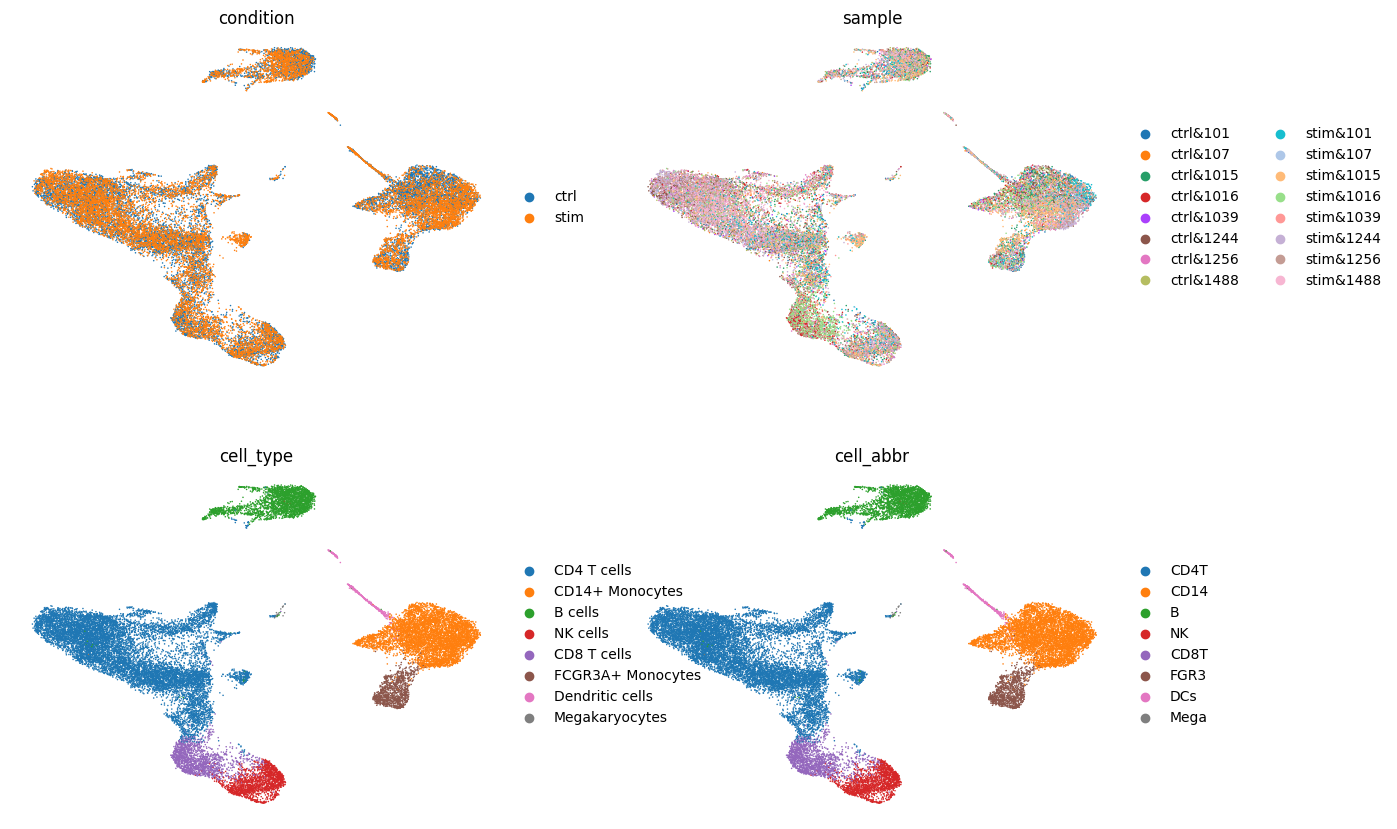

In [5]:
# Show pre-computed UMAP
sc.pl.umap(adata, color=[condition_key, sample_key, 'cell_type', groupby], frameon=False, ncols=2)

### Differential Testing Results

First, we need to generate pseudobulk profiles for each cell type, and we do so using the [`decoupler` package](https://decoupler-py.readthedocs.io/en/latest/notebooks/pseudobulk.html). 

In [6]:
pdata = dc.get_pseudobulk(
    adata,
    sample_col=sample_key,
    groups_col=groupby,
    layer='counts',
    mode='sum',
    min_cells=10,
    min_counts=10000
)
pdata

AnnData object with n_obs × n_vars = 110 × 15701
    obs: 'condition', 'cell_type', 'patient', 'sample', 'cell_abbr', 'psbulk_n_cells', 'psbulk_counts'
    var: 'name', 'n_cells'
    layers: 'psbulk_props'

We can plot the quality control metrics for each pseudobulk sample:

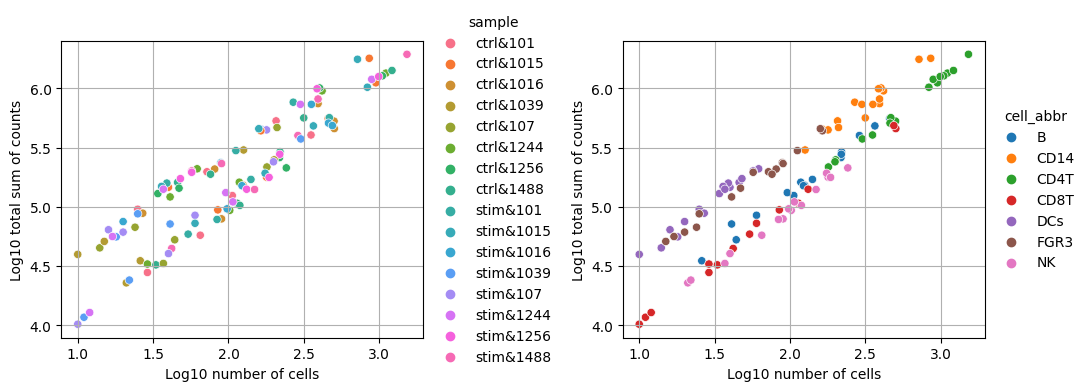

In [7]:
dc.plot_psbulk_samples(pdata, groupby=[sample_key, groupby], figsize=(11, 4))

#### Differential Expression Analysis

 Next, now that we have generated the pseudobulk profiles, we can perform some edgeR-like filtering, and then differential expression analysis using the [`pydeseq2` package](https://pydeseq2.readthedocs.io/en/latest/), a re-implementation of the original DESeq2 method ([Love et al., 2014](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-014-0550-8?ref=https://githubhelp.com)).

In [8]:
%%capture
dea_results = {}
for cell_group in pdata.obs[groupby].unique():
    # Select cell profiles
    ctdata = pdata[pdata.obs[groupby] == cell_group].copy()

    # Obtain genes that pass the edgeR-like thresholds
    genes = dc.filter_by_expr(ctdata, 
                              group=condition_key,
                              min_count=5, # a minimum number of counts in a number of samples
                              min_total_count=10 # a minimum total number of reads across samples
                              )
    # NOTE: These could differ between cell types, consider applying them by cell type

    # Filter by these genes
    ctdata = ctdata[:, genes].copy()
    
    # Build DESeq2 object
    dds = DeseqDataSet(
        adata=ctdata,
        design_factors=condition_key,
        ref_level=[condition_key, 'ctrl'], # Define control as reference
        refit_cooks=True,
        n_cpus=None,
    )
    
    # Compute LFCs
    dds.deseq2()
    # Contrast between stim and ctrl
    stat_res = DeseqStats(dds, contrast=[condition_key, 'stim', 'ctrl'], n_cpus=8)
    # Compute Wald test
    stat_res.summary()
    # Shrink LFCs
    stat_res.lfc_shrink(coeff='condition_stim_vs_ctrl') # {condition_key}_cond_vs_ref
    
    dea_results[cell_group] = stat_res.results_df
    

<div class="alert alert-info">

This results in a wall of currently unavoidable verbose text and prints, as such I use `%%capture` to hide it.

</div>  


In [9]:
# concat results across cell types
dea_df = pd.concat(dea_results)
dea_df = dea_df.reset_index().rename(columns={'level_0': groupby}).set_index('index')
dea_df.head()

,cell_abbr,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
index,,,,,,,
AAED1,B,7.282872,-0.134222,0.260852,-0.605923,0.544566,0.747988
AAMP,B,11.967019,-0.436868,0.185711,-2.523263,0.011627,0.047688
AARS,B,5.797380,0.180075,0.272438,0.782374,0.433995,0.660342
AASDHPPT,B,6.147571,0.184130,0.305030,0.741856,0.458175,0.679302
AATF,B,9.567191,-0.109027,0.254673,-0.493000,0.622013,0.802867


### DEA to Ligand-Receptor Interactions

Note that we have DEA results, we can use combine them into statistics of potentially deregulated ligand-receptor interactions.

To do so, liana provides a simple function `li.multi.dea_to_lr` that calculates average expression as well as proportions based on an AnnData object, and combines those with the DEA results. Since in this case we want to focus on gene statics relevant to the condition (stim); let's subset the adata to those and normalize the counts.

In [10]:
adata = adata[adata.obs[condition_key]=='stim'].copy()

In [11]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

Now that the data is normalized and subsetted, we can use the `li.multi.dea_to_lr` function to calculate the average expression and proportions, and combine them with the DEA results.

We need to additionally pass the names of the statistics from the DEA table in which we are interest, here we will use the adjusted p-values and Wald test statistic.

In [12]:
lr_res = li.multi.dea_to_lr(adata,
                            dea_df=dea_df,
                            expr_prop=0.1, # calculated for adata as passed - used to filter interactions
                            groupby=groupby, # NOTE: Needs to match a column in dea_df and adata.obs
                            stat_keys=['stat', 'pvalue', 'padj'],
                            use_raw=False,
                            complex_col='stat', # NOTE: here we use the Wald Statistic
                            verbose=True,
                            )

Using `.X`!
Converting mat to CSR format
227 features of mat are empty, they will be removed.


/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/pandas/core/indexing.py:1728: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.


0.74 of entities in the resource are missing from the data.


In [13]:
lr_res.head()

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_stat,ligand_pvalue,ligand_padj,ligand_expr,ligand_props,target,receptor_stat,receptor_pvalue,receptor_padj,receptor_expr,receptor_props,interaction_stat,interaction_pvalue,interaction_padj
0,LGALS9,PTPRC,LGALS9,PTPRC,CD4T,14.372896,7.656190e-47,6.875656e-45,0.225733,0.101973,CD4T,-1.900738,5.733632e-02,2.023241e-01,1.266398,0.501761,6.236079,2.866816e-02,1.011620e-01
1,LGALS9,CD44,LGALS9,CD44,CD4T,14.372896,7.656190e-47,6.875656e-45,0.225733,0.101973,CD4T,-4.982301,6.283262e-07,1.158633e-05,0.878007,0.364741,4.695297,3.141631e-07,5.793167e-06
2,VIM,CD44,VIM,CD44,CD4T,-3.642417,2.700902e-04,2.834103e-03,1.359541,0.519725,CD4T,-4.982301,6.283262e-07,1.158633e-05,0.878007,0.364741,-4.312359,1.353593e-04,1.422845e-03
3,PKM,CD44,PKM,CD44,CD4T,0.726290,4.676608e-01,7.146684e-01,0.667245,0.278267,CD4T,-4.982301,6.283262e-07,1.158633e-05,0.878007,0.364741,-2.128005,2.338307e-01,3.573400e-01
4,LGALS9,CD47,LGALS9,CD47,CD4T,14.372896,7.656190e-47,6.875656e-45,0.225733,0.101973,CD4T,10.753429,5.709875e-27,3.084671e-25,0.635388,0.272807,12.563162,2.854937e-27,1.542335e-25



##### Dealing with heteromeric complexes

LIANA will filter lowly-expressed interactions, i.e. those for which any of the genes are not expressed in at least 0.1 of the cells (by default) in the AnnData object. This can be adjusted with the `expr_prop` parameter. 

Moreover, to deal with complexes for each cell type, as either source or target of the potential CCC events, LIANA will find and assign the subunit of a complex with the lowest gene expression (by default) as the subunit of interest, and will then use the stats for that subunit as the stats of the whole protein complex.

<div class="alert alert-info">
This is a simple heuristic, and it is important to note that it is not perfect, as it will not work for all complexes. For example, if the subunit with lowest expression is not the one that is differentially expressed, the complex will not be detected as deregulated.

To this end, we also provide the option to provide a `complex_col` parameter, which will be used to assign the complex subunit of interest. This column should be a part of the `stat_keys`. Note that the **absolute minimum value** is used (i.e. the value closest to 0 is thought to be the 'worst' result), so this will not work for statistics with ascending values (e.g. p-values).
</div>  

### Process and Visualize the Results

Now that we have the interactions combined, let's keep only those in which either the ligand or receptor is differentially expressed.

In [14]:
lr_res = lr_res[(lr_res['ligand_padj'] < 0.05) | (lr_res['receptor_padj'] < 0.05)].copy()

We can then also use any of the stats, summarized at the level of the interaction, to prioritize the interactions, for example, we can use the mean Wald statistic between the ligand & receptor.

In [15]:
lr_res = lr_res.sort_values("interaction_stat", key=lambda x: np.abs(x), ascending=False)

<div class="alert alert-success">

Interaction_* columns are just the mean of the ligand and receptor columns of the corresponding statistic!
Please use with caution, as this is just a summary of the interaction that we can use to e.g. to sort the interactions as done above.
Instead, we recommend to use the ligand and receptor statistics **separately** to filter and plot the interactions
</div>



##### Visualize Potentially Deregulated Interactions

In [16]:
lr_res['interactions'] = lr_res['ligand'] + '&' + lr_res['receptor']
# only keep top interactions, else nan
lr_res['top_interactions'] = lr_res['interactions'].where(lr_res.index.isin(lr_res.index[:1]), np.nan)
# blue or red depending on sign of ligand or receptor, if both pos, red, if both neg, blue, if neither pos or neg, grey
lr_res['sign'] = lr_res[['ligand_stat', 'receptor_stat']].apply(lambda x: 
    'positive' if (x.ligand_stat > 0) & (x.receptor_stat > 0) 
    else 'negative' if (x.ligand_stat < 0) & (x.receptor_stat < 0)
    else 'neither', axis=1)

/home/dbdimitrov/anaconda3/envs/spiana/lib/python3.10/site-packages/plotnine/layer.py:411: PlotnineWarning: geom_label : Removed 1514 rows containing missing values.


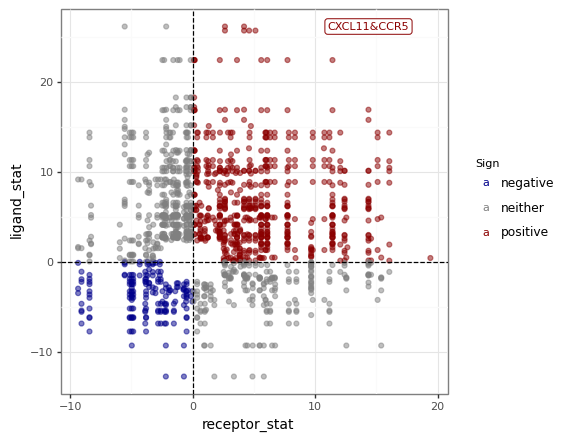

<ggplot: (8767368467952)>

In [23]:
### scatter plot of receptor and ligand stats
(
    p9.ggplot(lr_res, p9.aes(x='receptor_stat', y='ligand_stat', color='sign')) +
    p9.geom_point(alpha=0.5) +
    p9.scale_color_manual(['darkblue', 'grey', 'darkred']) +
    p9.geom_label(p9.aes(label='top_interactions'), size=8) +
    p9.geom_hline(yintercept=0, linetype='dashed') +
    p9.geom_vline(xintercept=0, linetype='dashed') +
    p9.theme_bw() +
    p9.theme(
        figure_size=(5, 5),
        axis_text=p9.element_text(size=8),
        axis_title=p9.element_text(size=10),
        legend_title=p9.element_text(size=8),
    ) +
    # add color as None
    p9.labs(color='Sign')
)